In [1]:
import geopandas as gpd
import os
import sys 
import pandas as pd
import numpy as np
import torch 
import scipy 
import geohash_hilbert as ghh
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
import glob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [113]:
path_sams_gs = './buildings/samples.geojson'
path_building = './buildings/samples_bld.geojson'
df = gpd.read_file(path_sams_gs).set_crs(3443, allow_override=True).to_crs(4326)
df['centers'] = df['geometry'].centroid
# df.head()

/var/folders/ys/r4mk__z94bb8wtyrhc9_c6_w0000gn/T/ipykernel_34569/1045170730.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centers'] = df['geometry'].centroid


In [56]:
class BBTree:
    def __init__(self, bath_to_directory, parent_precision=4, child_precision=6, train_split=0.1, path_images='/Users/ridhaalkhabaz/Documents/mlds/images/', path_labels='/Users/ridhaalkhabaz/Documents/mlds/labels/'):
        ## please note that our
        self.direc = gpd.read_file(bath_to_directory).set_crs(3443, allow_override=True).to_crs(4326) #please not 3443 projection key is only becasue samples.geojson is corrupted 
        self.direc['center'] = self.direc['geometry'].centroid
        self.parent_precision = parent_precision
        self.child_precision = child_precision
        self.tree = {}
        self.tree = self._init_tree()
        self.path_images = path_images
        self.path_labels = path_labels
    def _init_tree(self):
        part = {}
        n = len(self.direc)
        for i in range(n):
            ## find the record we hash 
            rec = self.direc.iloc[i]
            center = rec['center']
            ## getting the lon, lat for the sample 
            lng, lat = center.x, center.y
            ## geohash our sample 
            hash_child = ghh.encode(lng, lat, precision=self.child_precision)
            hash_parent = ghh.encode(lng, lat, precision=self.parent_precision)
            ## index the parent node if it does not exist 
            if part.get(hash_parent) is None:
                part[hash_parent] = {}
            ## index the parent node if it does not exist 
            if part[hash_parent].get(hash_child) is None:
                part[hash_parent][hash_child] = i 
        return part
    def _find_train_test_indxs(self, split):
        train_split = split 
        trainig_input = []
        for key in self.tree:
            sub_tree = self.tree.get(key)
            subtree_n  = len(sub_tree)
            num_recs = int(train_split*subtree_n)
            keys_list = list(sub_tree.keys())
            samples_kys = np.random.choice(keys_list, num_recs)
            samples_indx = [sub_tree.get(ky) for ky in samples_kys]
            trainig_input.extend(samples_indx)
        return trainig_input
    def _get_item_idx(self, key):
        if len(key) > self.parent_precision:
            parent_key = key[:self.parent_precision]
            desired = self.tree[parent_key].get(key)
            return desired 
        return 'check input'
    def _show_example(self, key, show_label=True):
        indx = self._get_item_idx(key)
        path_to_label = self.path_labels+'label_'+str(indx)+'.png'
        path_to_image = self.path_images+'imag_'+str(indx)+'.png'
        if show_label:
            label = np.array(Image.open(path_to_label))
            label[label > 0] = 255
            plt.imshow(label)
        else:
            plt.imshow(Image.open(path_to_image))
    def _get_subtree_indxs(self, key, breadth_search=False):
        desired_kys = [key]
        desired = []
        if breadth_search:
            desired_kys.extend(list(ghh.neighbours(key).values()))
        for key in desired_kys:
            desired.extend(self.tree[key].values())
        return desired 
    def _get_key(self, idx):
        if not isinstance(idx, int):
            return None 
        for key in self.tree.keys():
            if idx in list(self.tree[key].values()):
                for ky, indx in self.tree[key].items():
                    if idx == indx:
                        return ky
        return None 
        
    

In [57]:
indx = BBTree(path_sams_gs)

/var/folders/ys/r4mk__z94bb8wtyrhc9_c6_w0000gn/T/ipykernel_34569/148815098.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.direc['center'] = self.direc['geometry'].centroid


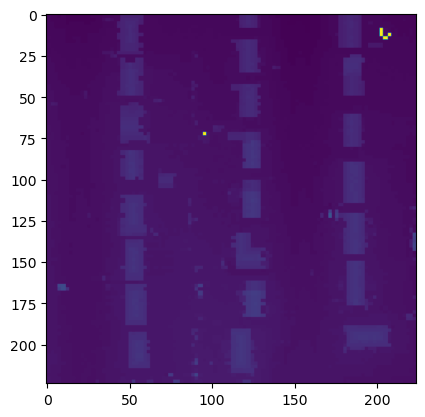

In [160]:
indx._show_example('SLZZux', False) #49164

In [169]:
indx._get_item_idx('SLZZux')

33179

In [171]:
indx._get_key(0)

'SLbJlD'

In [6]:
def numIslands(grid):
    rows, cols = len(grid), len(grid[0])
    num_islands = 0

    def dfs(r, c):
        if r < 0 or c < 0 or r >= rows or c >= cols or grid[r][c] == 0:
            return
        grid[r][c] = 0
        dfs(r + 1, c)
        dfs(r - 1, c)
        dfs(r, c + 1)
        dfs(r, c - 1)

    for r in range(rows):
        for c in range(cols):
            if grid[r][c] != 0:
                num_islands += 1
                dfs(r, c)

    return num_islands

In [89]:
class filter_dataset(Dataset):
    def __init__(self, indices, metadata_path=path_building, path_images= '/Users/ridhaalkhabaz/Documents/mlds/images/', path_labels='/Users/ridhaalkhabaz/Documents/mlds/labels/'):
        self.indices = indices
        self.data = []
        self.imgs_path = path_images
        self.labs_path = path_labels
        self.df_meta = gpd.read_file(metadata_path)
        for indx in indices:
            # path_to_label = self.labs_path+'label_'+str(indx)+'.png'
            path_to_image = self.imgs_path+'imag_'+str(indx)+'.png'
            # mask = np.array(Image.open(path_to_label))
            # label = numIslands(mask)
            label_ind = self.df_meta.iloc[indx]['FID']
            label = 1 if label_ind > 0 else 0
            self.data.append([path_to_image, label])
        self.img_dim = (224, 224)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.array(Image.open(img_path))
        # img = np.expand_dims(img, axis=0)
        class_id = class_name
        img_tensor = torch.tensor(img).to(torch.int32)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [90]:
# train_indxs = indx._find_train_test_indxs(0.1)
# test_indxs = indx._find_train_test_indxs(0.05)
train_dataset = filter_train_dataset(train_indxs)
test_dataset = filter_train_dataset(test_indxs)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [91]:
img, label = train_dataset.__getitem__(0)
print(img.dtype, label.dtype)

torch.uint8 torch.int64


In [75]:
input_shape = 1
learning_rate =0.0001
model = torch.nn.Sequential(
        torch.nn.Linear(input_shape,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,64),
        torch.nn.ReLU(),
        torch.nn.Linear(32,64)
        )
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss = torch.nn.BCELoss()

In [76]:
losses = []
accur = []
model.train()
epochs = 100
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(train_loader):
    print(x_train.dtype)
    print(y_train.dtype)
    #calculate output
    output = model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = model(torch.tensor(x,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

torch.uint8
torch.int64


RuntimeError: mat1 and mat2 must have the same dtype, but got Byte and Float

In [12]:
tmp = df.iloc[trainig_input]
tmp.plot()

NameError: name 'df' is not defined

In [149]:
cen = df.iloc[33179]['centers']
ghh.encode(cen.x, cen.y, precision=6)

'SLZZux'

In [105]:
tmp2 = blds.iloc[trainig_input]
len(tmp2[tmp2['FID']>0])

959

<Axes: >

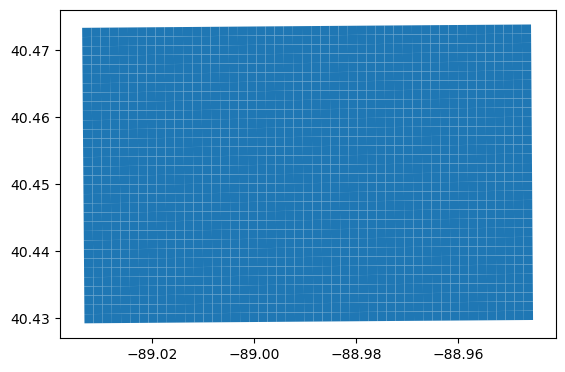

In [140]:
indicex = list(indx.tree['SLZ_'].values())
df.iloc[indicex].plot()

In [144]:
indx.tree['SLY7'].keys()

dict_keys(['SLY7ed', 'SLY7eh', 'SLY7ei', 'SLY7en', 'SLY7ex', 'SLY7ew', 'SLY7f1', 'SLY7f7', 'SLY7f6', 'SLY7ft', 'SLY7fx', 'SLY7fy', 'SLY7g3', 'SLY7g2', 'SLY7gB', 'SLY7e_', 'SLY7eY', 'SLY7eV', 'SLY7ep', 'SLY7et', 'SLY7eu', 'SLY7fE', 'SLY7fA', 'SLY7f@', 'SLY7fp', 'SLY7fn', 'SLY7fk', 'SLY7g5', 'SLY7g6', 'SLY7g@', 'SLY7eO', 'SLY7eS', 'SLY7eT', 'SLY7eA', 'SLY7e7', 'SLY7e4', 'SLY7fI', 'SLY7fS', 'SLY7fR', 'SLY7fY', 'SLY7fh', 'SLY7fg', 'SLY7gv', 'SLY7gs', 'SLY7go', 'SLY7eK', 'SLY7eI', 'SLY7eF', 'SLY7eE', 'SLY7e1', 'SLY7e0', 'SLY7fK', 'SLY7fO', 'SLY7fP', 'SLY7f_', 'SLY7fd', 'SLY7fe', 'SLY7gz', 'SLY7gy', 'SLY7gk', 'SLY7dd', 'SLY7dh', 'SLY7di', 'SLY7dn', 'SLY7dx', 'SLY7dw', 'SLY7cf', 'SLY7cb', 'SLY7cZ', 'SLY7cQ', 'SLY7cM', 'SLY7cJ', 'SLY7h1', 'SLY7h2', 'SLY7h6', 'SLY7d_', 'SLY7dY', 'SLY7dV', 'SLY7dp', 'SLY7dt', 'SLY7du', 'SLY7cj', 'SLY7cW', 'SLY7cV', 'SLY7cU', 'SLY7cG', 'SLY7cF', 'SLY7hE', 'SLY7hB', 'SLY7h@', 'SLY7dO', 'SLY7dS', 'SLY7dT', 'SLY7dA', 'SLY7d7', 'SLY7d4', 'SLY7cl', 'SLY7cr', 'SLY7cq',

In [108]:
len(tmp2[tmp2['FID']>0])/len(trainig_input)

0.14592209373097992

In [26]:
point = df_sams_csv.iloc[33178]['x']
print(np.abs(s.x - point)>1e-5)

True


<Axes: >

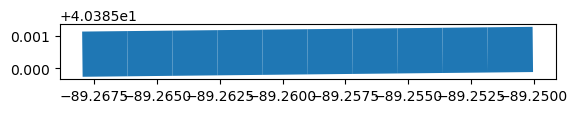

In [37]:
df.iloc[:10].plot()

In [18]:
df_sams_csv = pd.read_csv('./buildings/samples_buildings.csv')
df_sams_csv.iloc[33179]

Unnamed: 0    33179.000000
id            33179.000000
FID              26.000000
area           3873.938730
percentage        0.166797
x               -88.946735
y                40.491018
Name: 33179, dtype: float64

<Axes: >

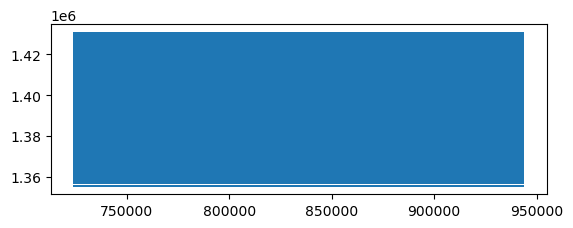

In [3]:
tmp = df.set_crs(3443, allow_override=True)
tmp.plot()

<Axes: >

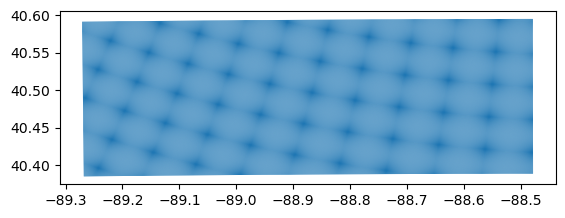

In [4]:
tmp2 = tmp.to_crs(4326)
tmp2.plot()

/Users/ridhaalkhabaz/opt/anaconda3/envs/conversat/lib/python3.9/site-packages/geopandas/plotting.py:718: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

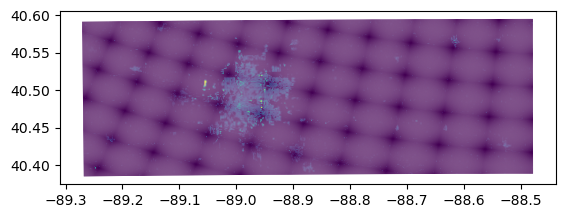

In [7]:
blds = gpd.read_file(path_building).set_crs(3443, allow_override=True)
blds = blds.to_crs(4326)
blds.plot(column='area')

In [8]:
blds.head()

,id,FID,area,geometry
0,0,0.0,0.0,"POLYGON ((-89.26617 40.38476, -89.26619 40.386..."
1,1,0.0,0.0,"POLYGON ((-89.26438 40.38478, -89.26440 40.386..."
2,2,0.0,0.0,"POLYGON ((-89.26258 40.38479, -89.26260 40.386..."
3,3,0.0,0.0,"POLYGON ((-89.26079 40.38481, -89.26081 40.386..."
4,4,0.0,0.0,"POLYGON ((-89.25899 40.38482, -89.25901 40.386..."


In [19]:
blds[blds['area']>23224.0]

,id,FID,area,geometry
38399,38399,1.0,23224.885450,"POLYGON ((-89.05386 40.50625, -89.05388 40.507..."
38839,38839,1.0,23224.885451,"POLYGON ((-89.05388 40.50763, -89.05389 40.509..."
39279,39279,1.0,23224.885450,"POLYGON ((-89.05389 40.50901, -89.05391 40.510..."
39719,39719,1.0,23224.885451,"POLYGON ((-89.05391 40.51039, -89.05392 40.511..."


In [21]:
df = pd.read_csv('./buildings/centers.csv')
df.h

In [22]:
df.head()

,Unnamed: 0,centroid,x,y
0,0,POINT (-89.26708652847677 40.38544918825039),-89.267087,40.385449
1,1,POINT (-89.26529170949608 40.38546366787838),-89.265292,40.385464
2,2,POINT (-89.26349688921479 40.38547811965417),-89.263497,40.385478
3,3,POINT (-89.26170206763534 40.38549254357772),-89.261702,40.385493
4,4,POINT (-89.25990724476026 40.38550693964897),-89.259907,40.385507


In [94]:
mapping = {key:i for i,key in enumerate(list(indx.tree.keys()))}

In [27]:
blds.iloc[39719]

id                                                      39719
FID                                                       1.0
area                                             23224.885451
geometry    POLYGON ((-89.05390830917717 40.51039011138188...
Name: 39719, dtype: object

In [112]:
def mapp_cat(idx):
    mapping = {key:i for i,key in enumerate(list(indx.tree.keys()))}
    key = indx._get_key(idx)
    k = key[:4]
    return mapping.get(k)


In [114]:
df['idx'] = [i for i in range(len(df))]
df['cat'] = df['idx'].apply(mapp_cat)
df.head()

,geometry,centers,idx,cat
0,"POLYGON ((-89.26617 40.38476, -89.26619 40.386...",POINT (-89.26708 40.38544),0,0
1,"POLYGON ((-89.26438 40.38478, -89.26440 40.386...",POINT (-89.26529 40.38546),1,0
2,"POLYGON ((-89.26258 40.38479, -89.26260 40.386...",POINT (-89.26349 40.38547),2,0
3,"POLYGON ((-89.26079 40.38481, -89.26081 40.386...",POINT (-89.26170 40.38549),3,0
4,"POLYGON ((-89.25899 40.38482, -89.25901 40.386...",POINT (-89.25990 40.38550),4,0


/Users/ridhaalkhabaz/opt/anaconda3/envs/conversat/lib/python3.9/site-packages/geopandas/plotting.py:718: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


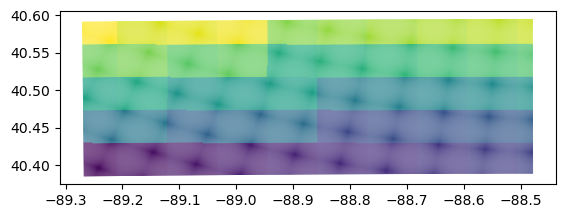

In [119]:
df.plot(column='cat')
plt.savefig('partition.jpeg')

<Axes: >

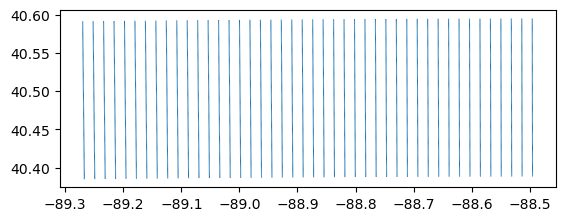

In [124]:
indcs = [i for i in range(0, len(df), 10)]
tmp = df.iloc[indcs]
tmp.plot()


<Axes: >

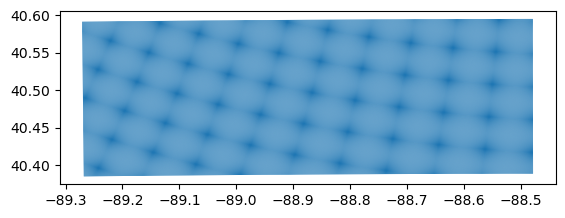

In [121]:
df.plot()